In [26]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\keep_\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [58]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import ngrams
from collections import Counter

In [1]:
path = kagglehub.dataset_download("raj713335/twittesentimentanalysis")

print("Path to dataset files:", path)

tweets = pd.read_csv(f"{path}/tweets.csv", encoding = "ISO-8859-1", names= ["Target", "ID", "Date", "Query", "User", "Text"], header=None)

tweets.head()

Path to dataset files: C:\Users\keep_\.cache\kagglehub\datasets\raj713335\twittesentimentanalysis\versions\1


,Target,ID,Date,Query,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [104]:
tweets['Target'] = tweets['Target'].astype('category')
tweets['Date'] = pd.to_datetime(tweets['Date'])

C:\Users\keep_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


## Basic Dataset Statistics:
- Total number of tweets
- Number of unique users
- Time range of tweets
- Distribution of tweet lengths
- Missing values analysis

### Total number of tweets

In [111]:
tweets.shape[0]

1600000

### Number of unique users

In [99]:
tweets['User'].nunique()

659775

### Time range of tweets

In [105]:
oldest_date=tweets['Date'].min()
newest_date=tweets['Date'].max()

print(f"Oldest: {oldest_date}\nNewest: {newest_date}")

Oldest: 2009-04-06 22:19:45
Newest: 2009-06-25 10:28:31


## Sentiment Distribution:
- Count/percentage of each sentiment category (positive, negative, neutral)

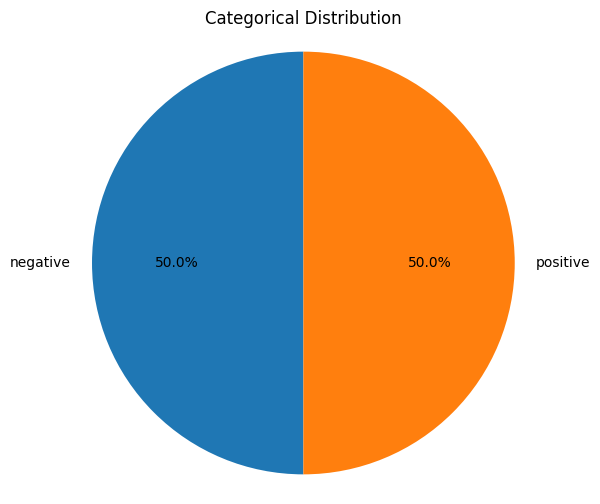

In [106]:
plt.figure(figsize=(6, 6))
plt.pie(tweets['Target'].value_counts(), labels=['negative', 'positive'], autopct='%1.1f%%', startangle=90)
plt.title("Categorical Distribution")
plt.axis('equal')
plt.show()

## Text Analysis

- Word frequency distribution
- Most common words (word clouds)
- N-grams analysis (most common bi-grams and tri-grams)
- Average word count per sentiment category
- Hashtag analysis and frequency
- Mention (@) analysis

In [63]:
def plot_sentiment_word_comparison(positive_df, negative_df, top_n=20):
    # Get the top N words from each sentiment
    top_pos = set(positive_df['word'].head(top_n))
    top_neg = set(negative_df['word'].head(top_n))
    
    # Find common words
    common_words = top_pos.intersection(top_neg)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'word': list(common_words),
        'Positive': [positive_df[positive_df['word'] == word]['count'].iloc[0] 
                    for word in common_words],
        'Negative': [negative_df[negative_df['word'] == word]['count'].iloc[0] 
                    for word in common_words]
    })
    
    # Sort by total frequency
    comparison_df['total'] = comparison_df['Positive'] + comparison_df['Negative']
    comparison_df = comparison_df.sort_values('total', ascending=True)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Plot horizontal bars
    y_pos = np.arange(len(comparison_df))
    width = 0.35
    
    # Create bars
    ax.barh(y_pos - width/2, comparison_df['Positive'], width, 
            label='Positive', color='#2ecc71', alpha=0.7)
    ax.barh(y_pos + width/2, comparison_df['Negative'], width,
            label='Negative', color='#e74c3c', alpha=0.7)
    
    # Customize the plot
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    ax.set_title('Word Frequencies in Positive vs Negative Tweets')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(comparison_df['word'])
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, axis='x', alpha=0.3)
    
    # Add value labels on the bars
    for i, v in enumerate(comparison_df['Positive']):
        ax.text(v, i - width/2, str(v), va='center', fontweight='bold')
    for i, v in enumerate(comparison_df['Negative']):
        ax.text(v, i + width/2, str(v), va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [64]:
def plot_top_words(freq_df, n=20):
    plt.figure(figsize=(15, 6))
    sns.barplot(data=freq_df.head(n), x=freq_df.word[:n], y='count')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {n} Most Frequent Words')
    plt.tight_layout()
    plt.show()

In [65]:
def analyze_ngrams(df, text_column='Text', n=2, top_k=20):
    """
    Comprehensive n-gram analysis with visualization
    """
    # Preprocess and generate n-grams
    ngram_counts = Counter()
    
    for text in df[text_column]:
        # Convert to lowercase and tokenize
        tokens = str(text).lower().split()
        # Generate n-grams
        text_ngrams = list(ngrams(tokens, n))
        # Update counts
        ngram_counts.update(text_ngrams)
    
    # Convert to DataFrame
    ngram_df = pd.DataFrame([(' '.join(k), v) for k, v in ngram_counts.items()],
                           columns=['ngram', 'frequency'])
    
    # Sort by frequency
    ngram_df = ngram_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    
    # Plot top k n-grams
    plt.figure(figsize=(15, 8))
    sns.barplot(data=ngram_df.head(top_k), x='frequency', y='ngram')
    plt.title(f'Top {top_k} {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.tight_layout()
    plt.show()
    
    return ngram_df

### Word frequency distribution

In [55]:
word_frequency = tweets['Text'].str.lower().str.findall(r"(?:^|\s)([a-zA-Z'-]+)(?:[\s.,!?;]|$)").explode().value_counts()

In [36]:
word_freq_df = word_frequency.reset_index()
word_freq_df.columns = ['word', 'count']

word_freq_df.head()

,word,count
0,i,550581
1,the,274253
2,to,271955
3,a,184543
4,and,180962


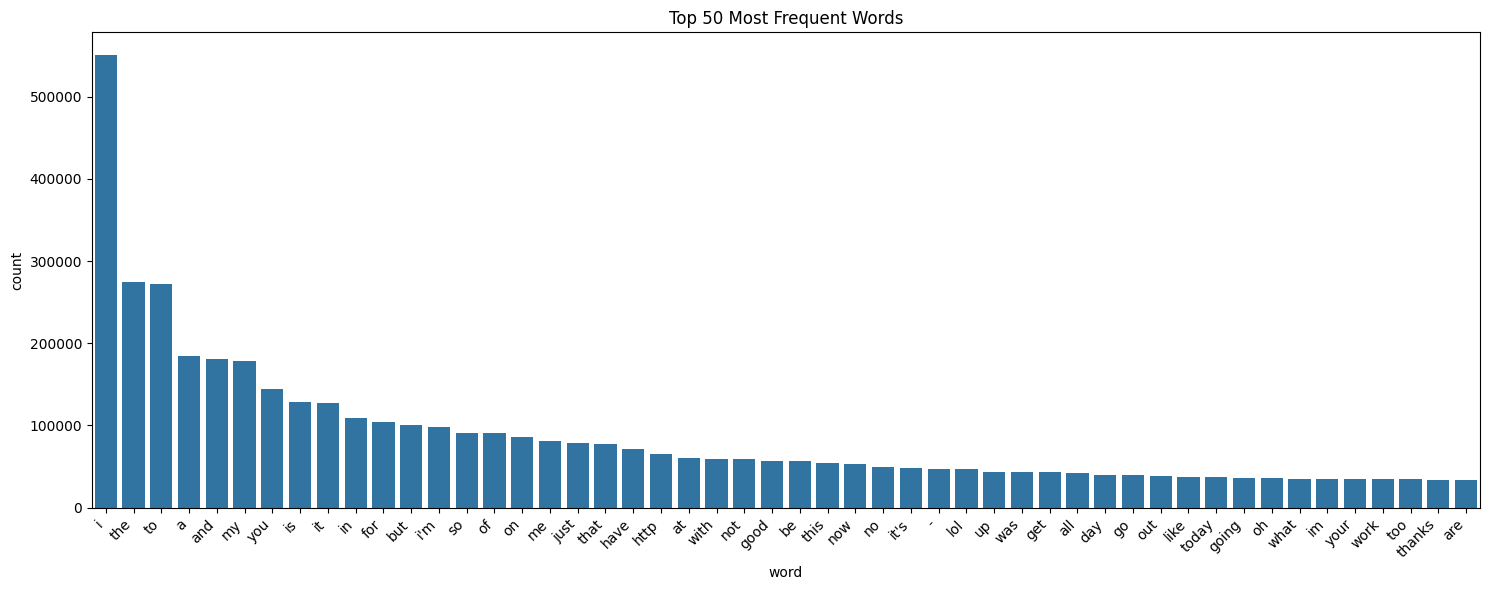

In [ ]:
plot_top_words(word_freq_df, 50)

### Most common words (word clouds)

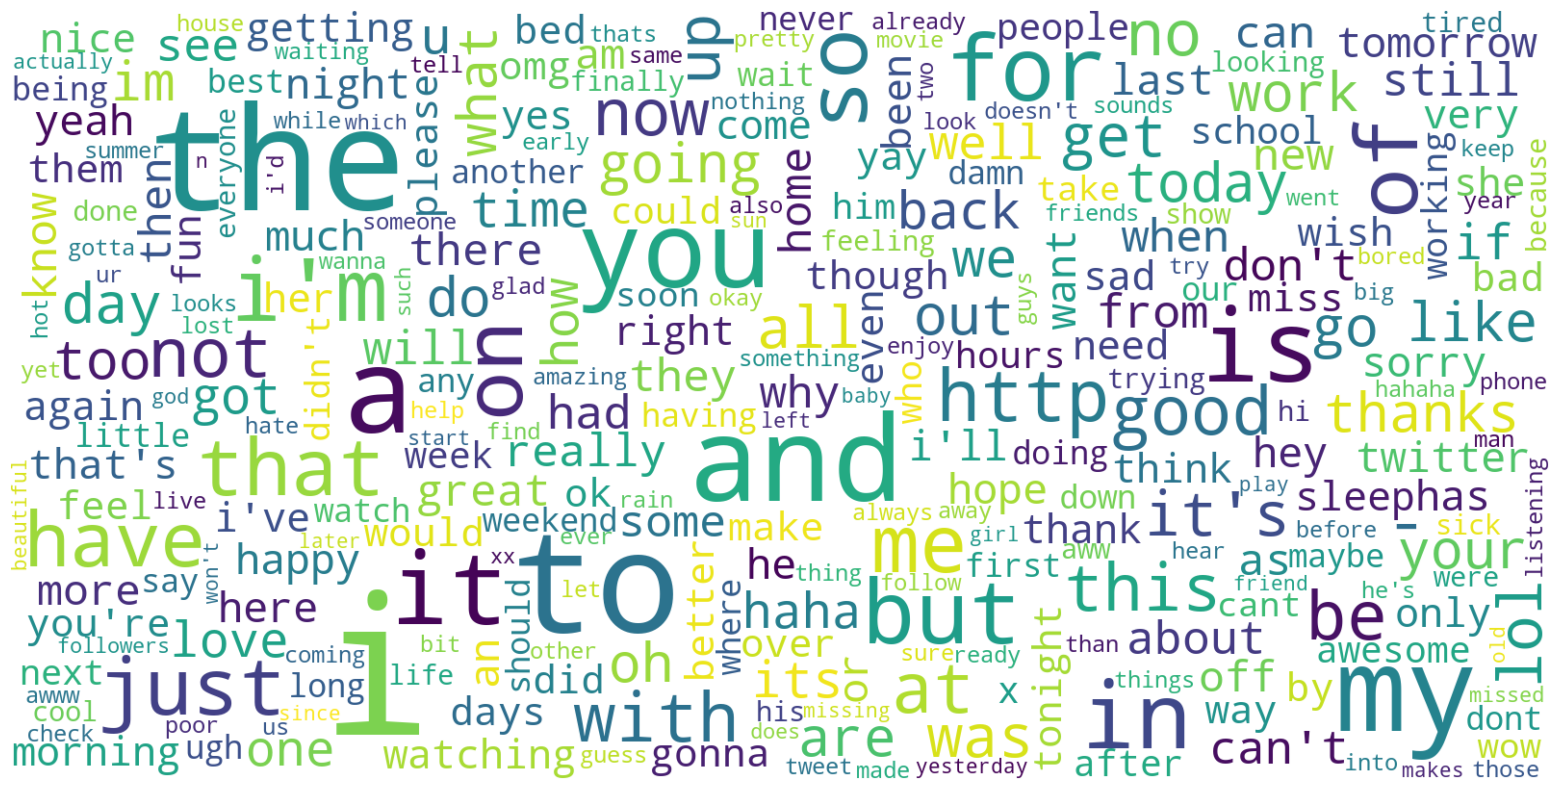

In [42]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1600, 
    height=800,
    background_color='white',
    max_words=300,
    max_font_size=200,
    min_font_size=10,
    random_state=1
).generate_from_frequencies(word_freq_df.set_index('word').to_dict()['count'])
    
    # Display
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### N-grams analysis (most common bi-grams and tri-grams)

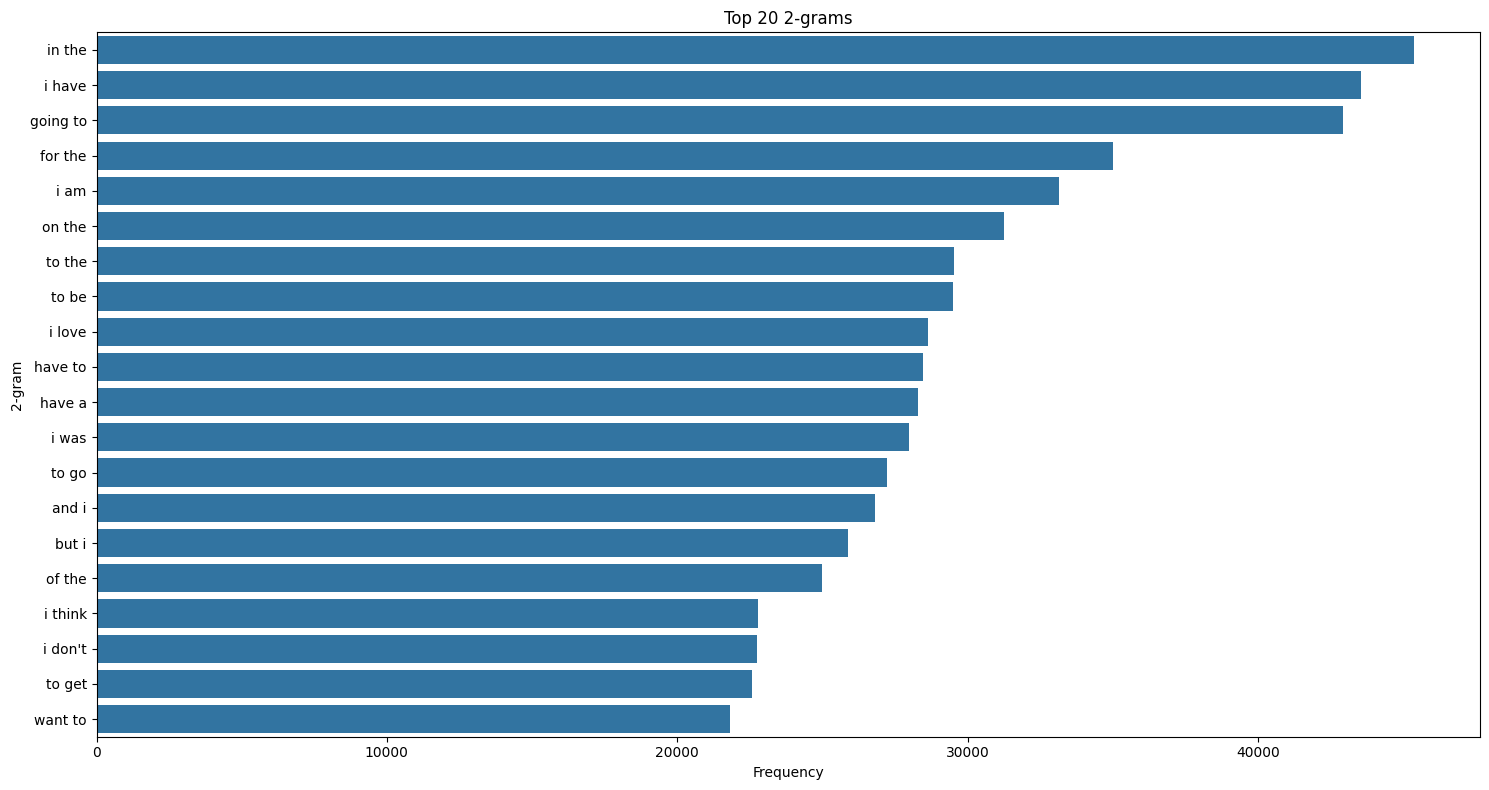

In [46]:
bigram_df = analyze_ngrams(tweets, n=2, top_k=20)

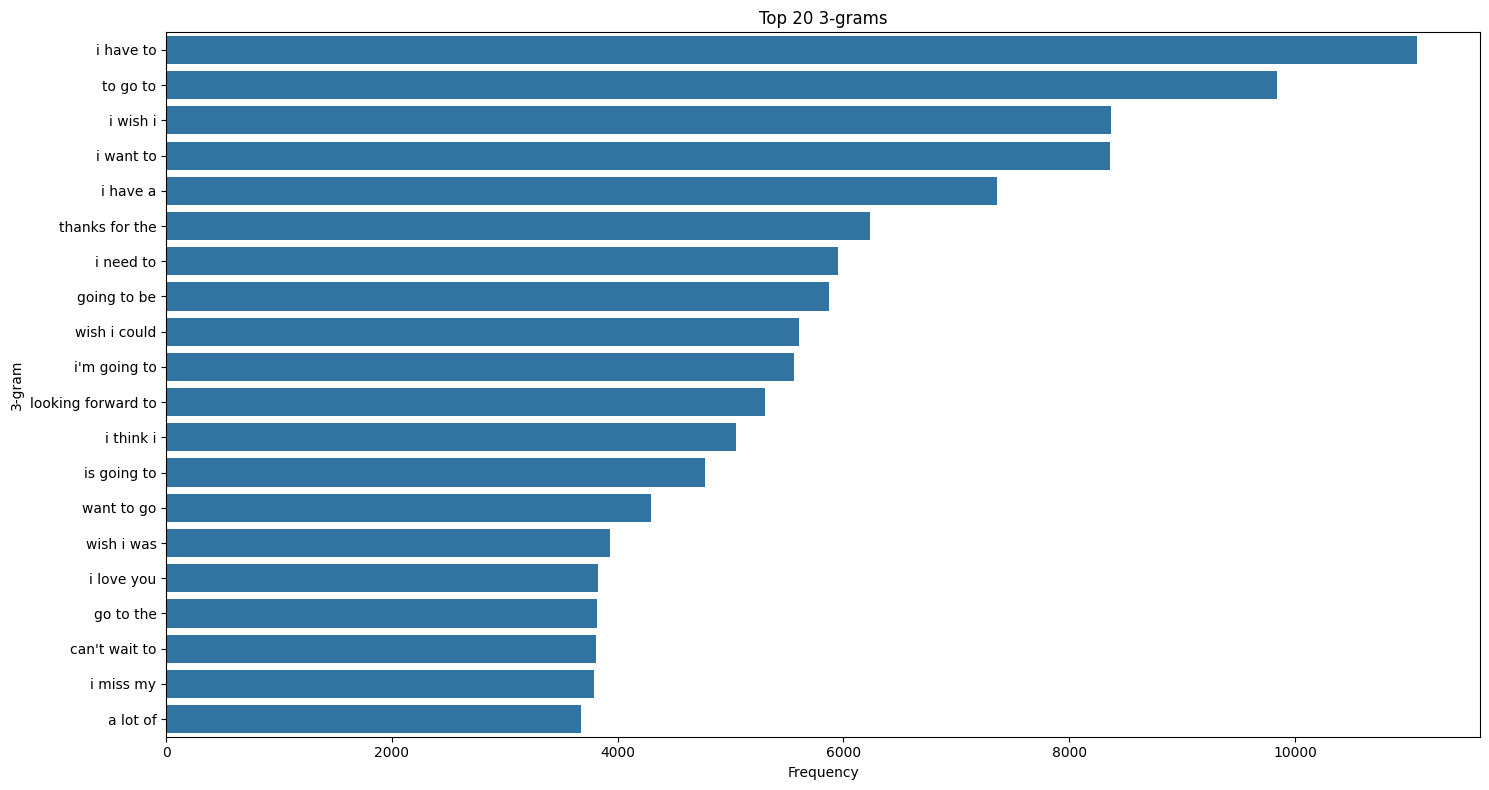

In [113]:
trigram_df = analyze_ngrams(tweets, n=3, top_k=20)

### Average word count per sentiment category

In [54]:
positive_word_freq_df = tweets[tweets['Target'] == 4]['Text'].str.lower().str.findall(r"(?:^|\s)([a-zA-Z'-]+)(?:[\s.,!?;]|$)").explode().value_counts().reset_index()
positive_word_freq_df.columns = ['word', 'count']

negative_word_freq_df = tweets[tweets['Target'] == 0]['Text'].str.lower().str.findall(r"(?:^|\s)([a-zA-Z'-]+)(?:[\s.,!?;]|$)").explode().value_counts().reset_index()
negative_word_freq_df.columns = ['word', 'count']

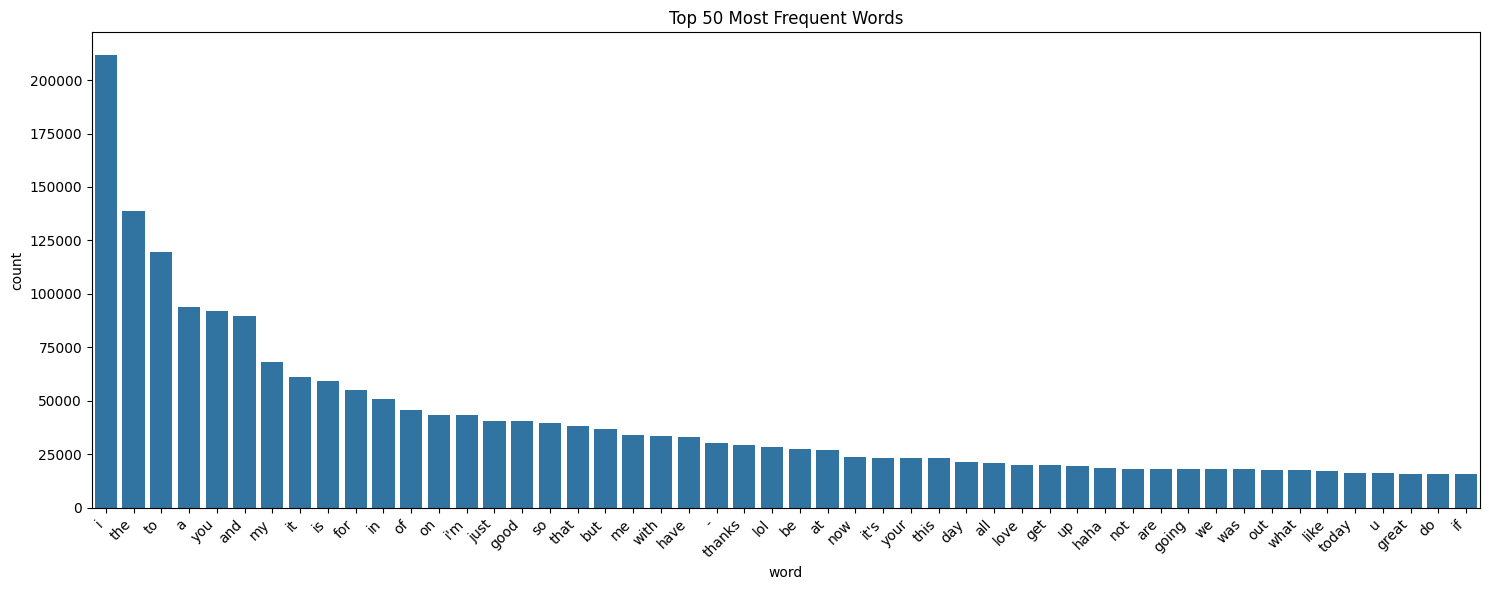

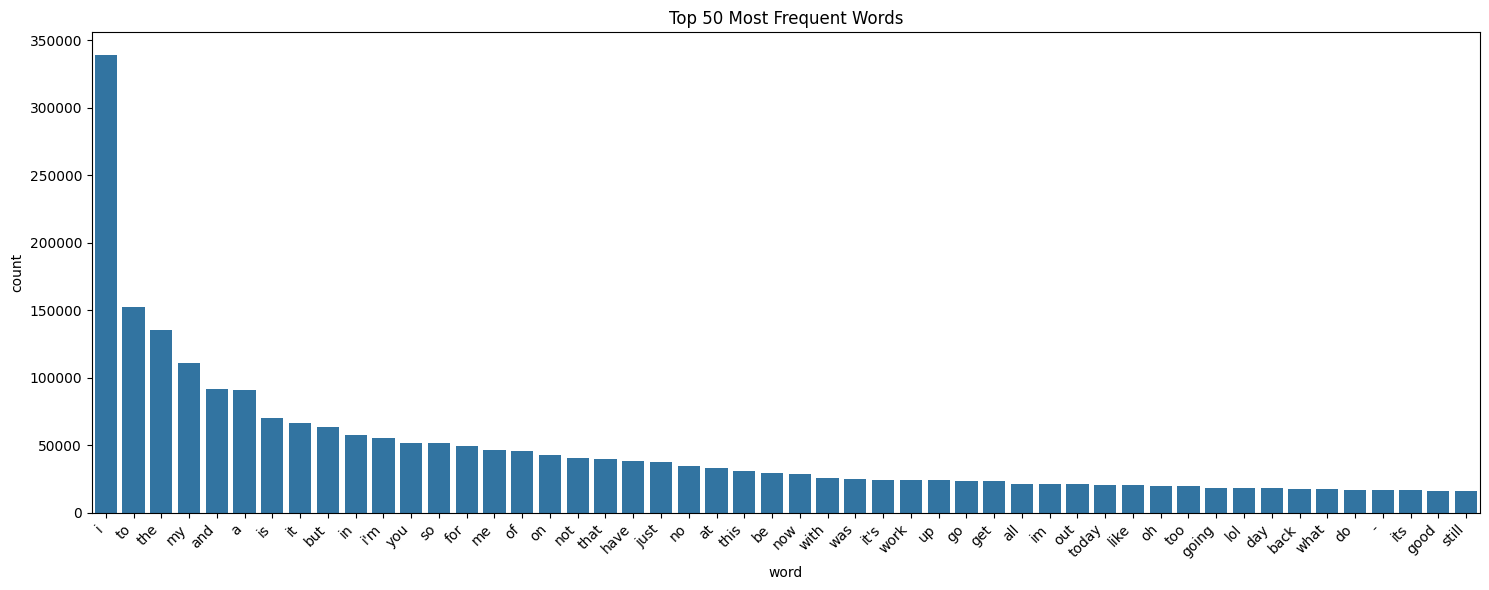

In [56]:
plot_top_words(positive_word_freq_df, 50)
plot_top_words(negative_word_freq_df, 50)

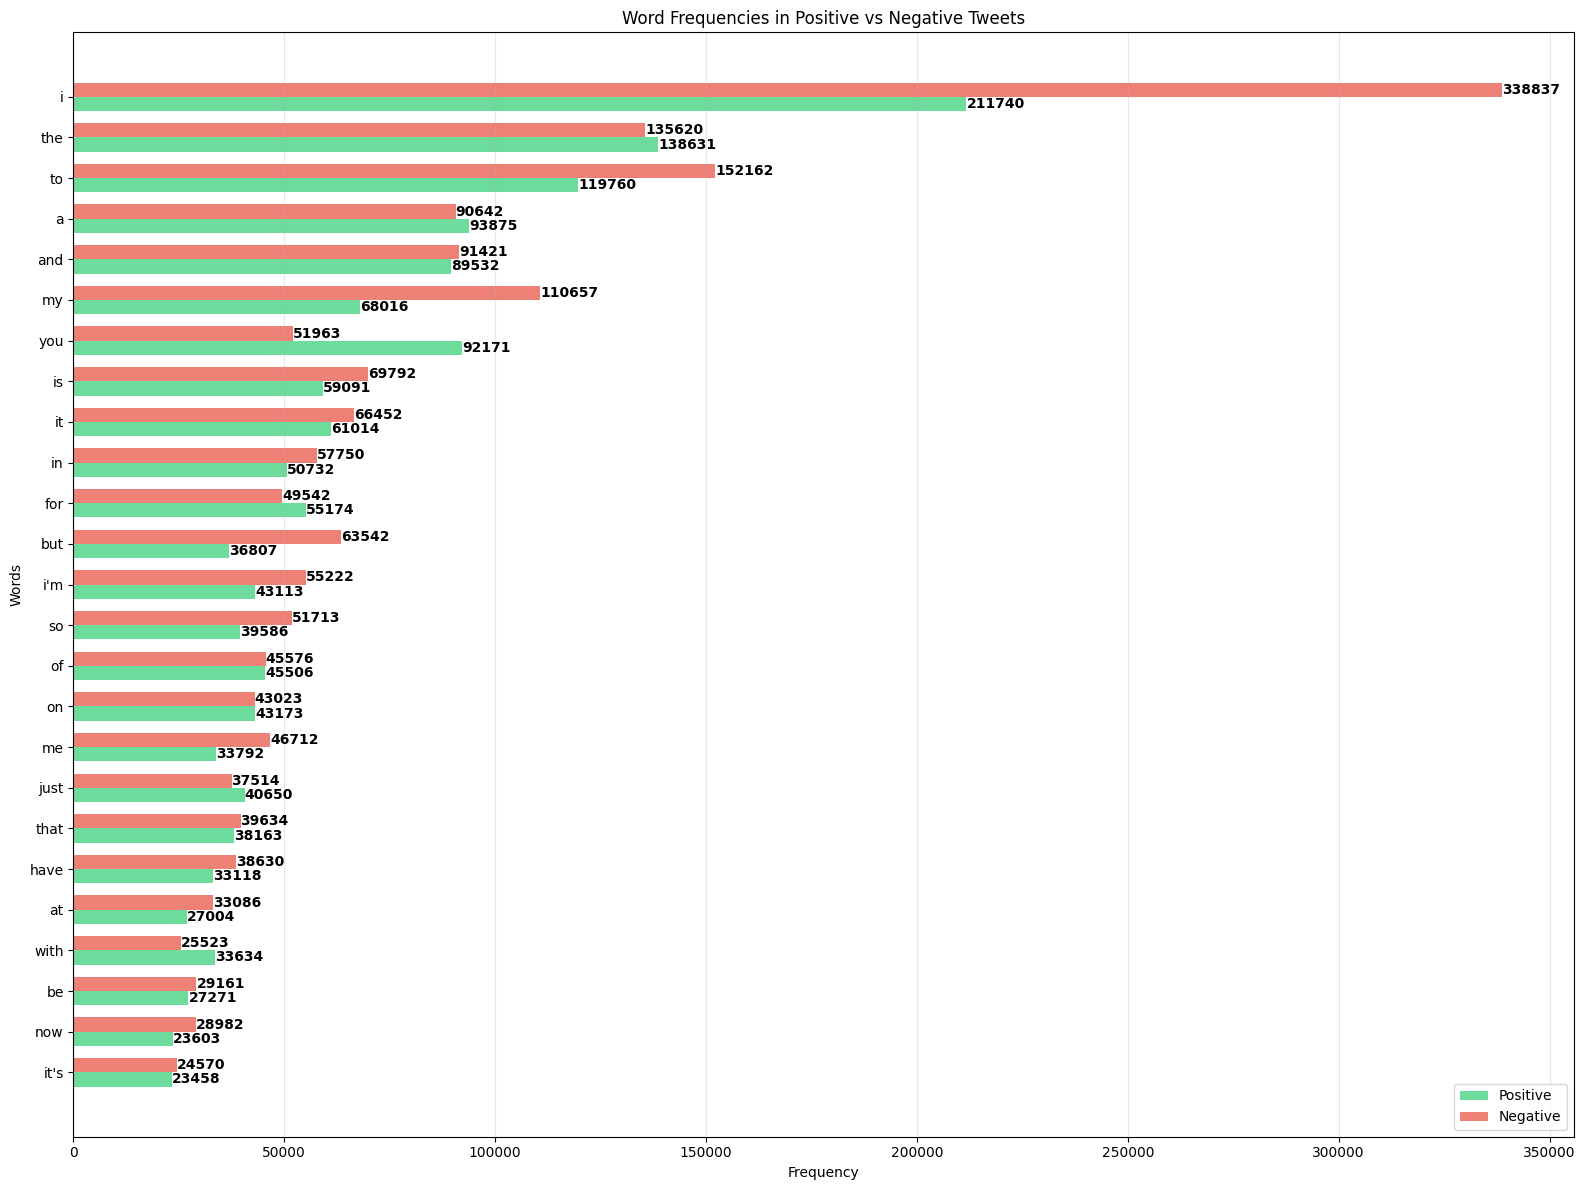

In [71]:
comparison_data = plot_sentiment_word_comparison(positive_word_freq_df, 
                                               negative_word_freq_df, 
                                               top_n=30)

### Hashtag analysis and frequency

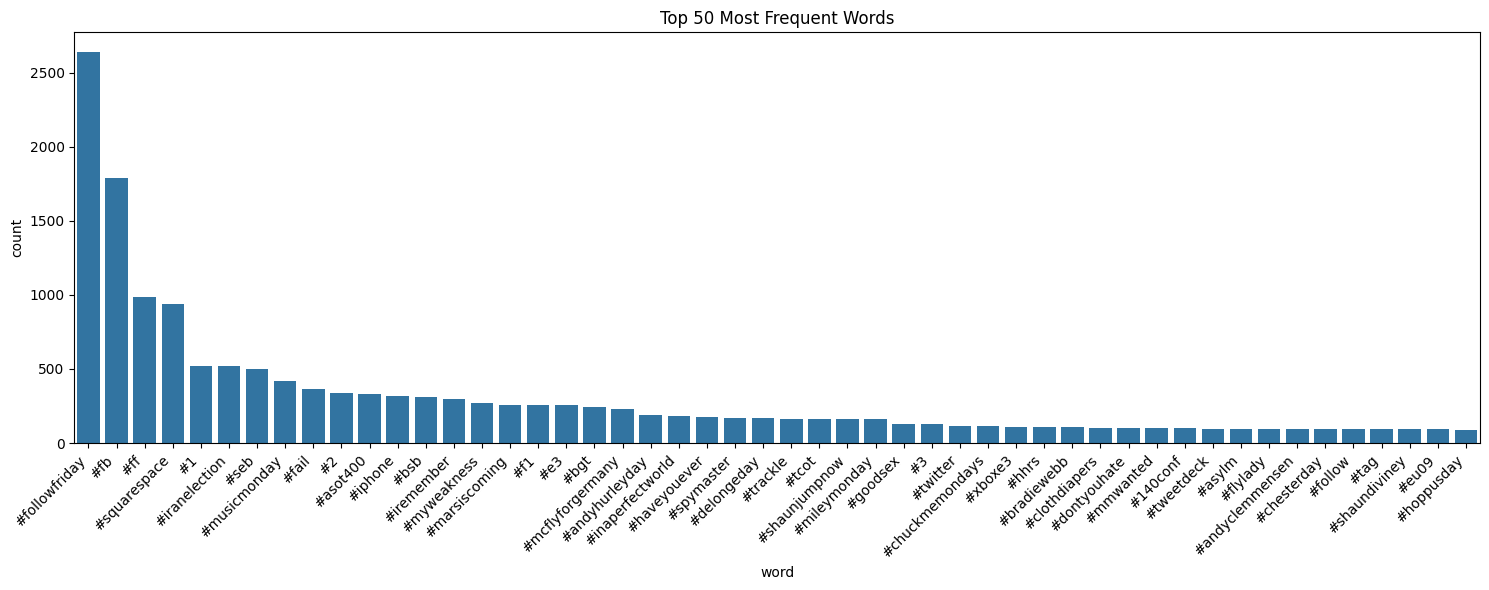

In [68]:
hashtag_freq_df = tweets['Text'].str.lower().str.findall(r'#\w+').explode().value_counts().reset_index()
hashtag_freq_df.columns = ['word', 'count']
plot_top_words(hashtag_freq_df, 50)

In [69]:
positive_hashtag_freq_df = tweets[tweets['Target'] == 4]['Text'].str.lower().str.findall(r'#\w+').explode().value_counts().reset_index()
positive_hashtag_freq_df.columns = ['word', 'count']

negative_hashtag_freq_df = tweets[tweets['Target'] == 0]['Text'].str.lower().str.findall(r'#\w+').explode().value_counts().reset_index()
negative_hashtag_freq_df.columns = ['word', 'count']

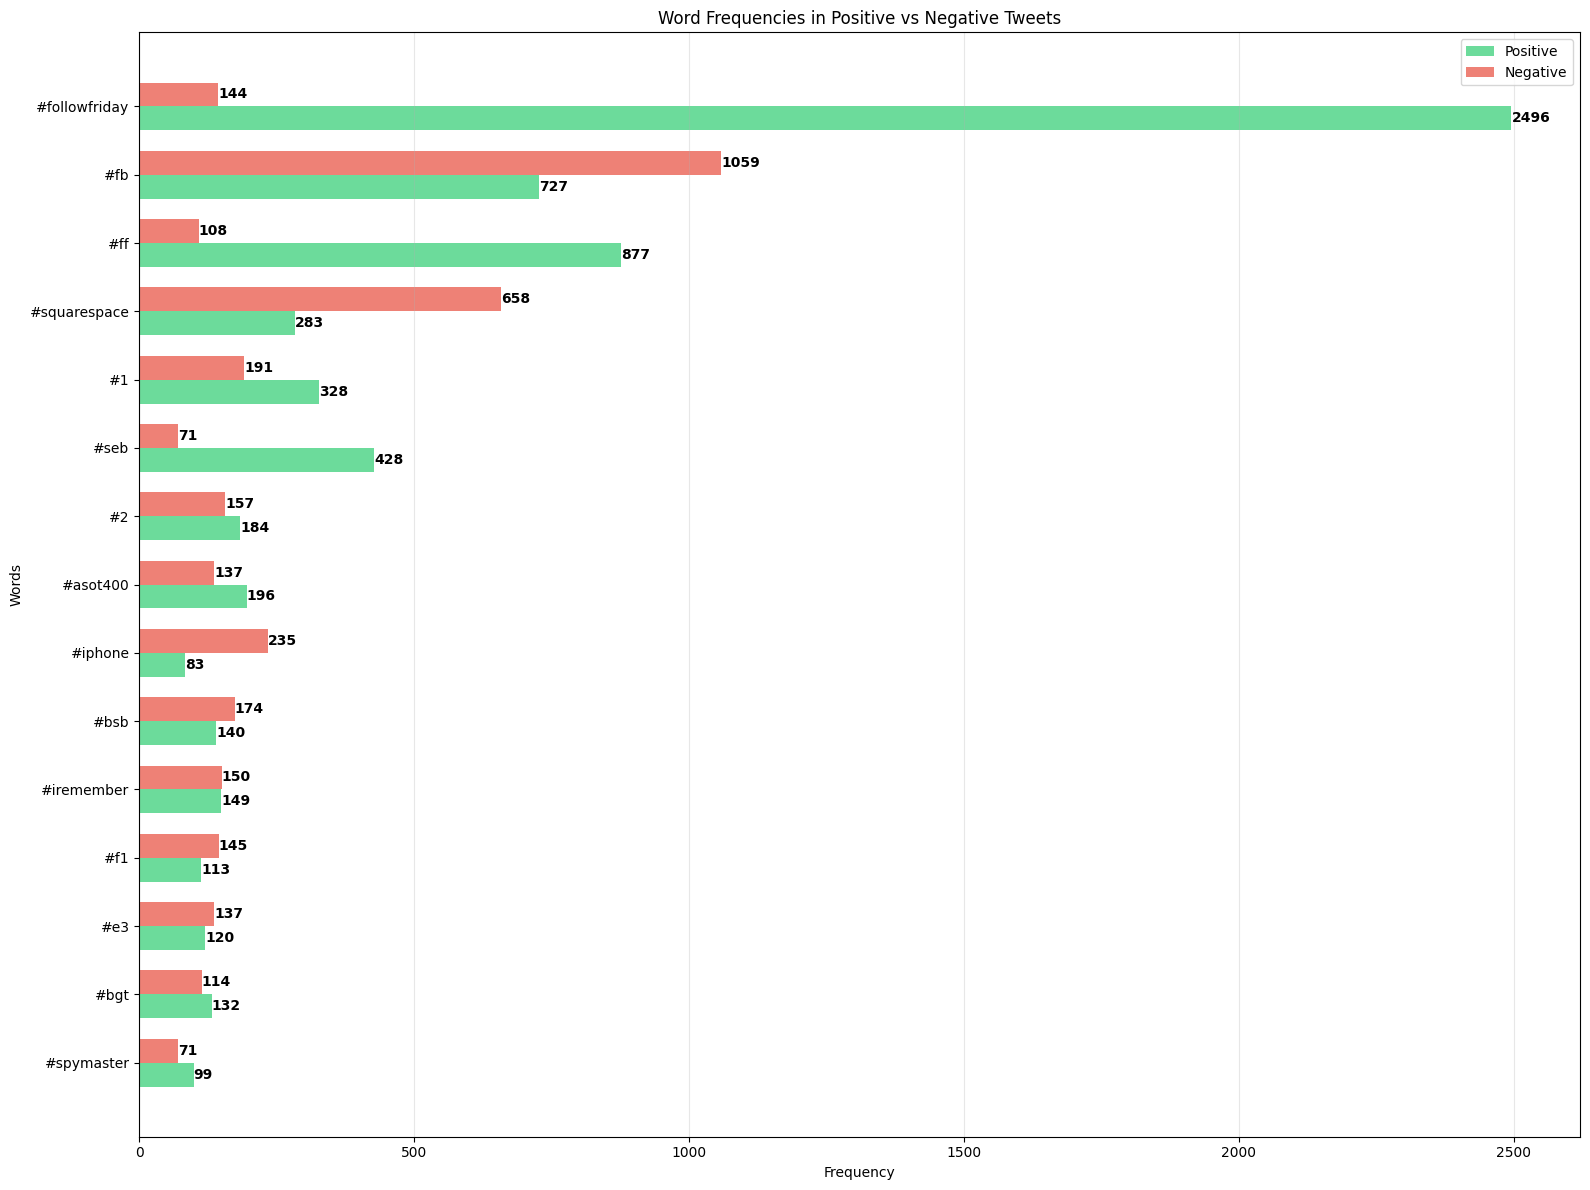

In [70]:
comparison_data = plot_sentiment_word_comparison(positive_hashtag_freq_df, 
                                               negative_hashtag_freq_df, 
                                               top_n=30)

### Mention (@) analysis

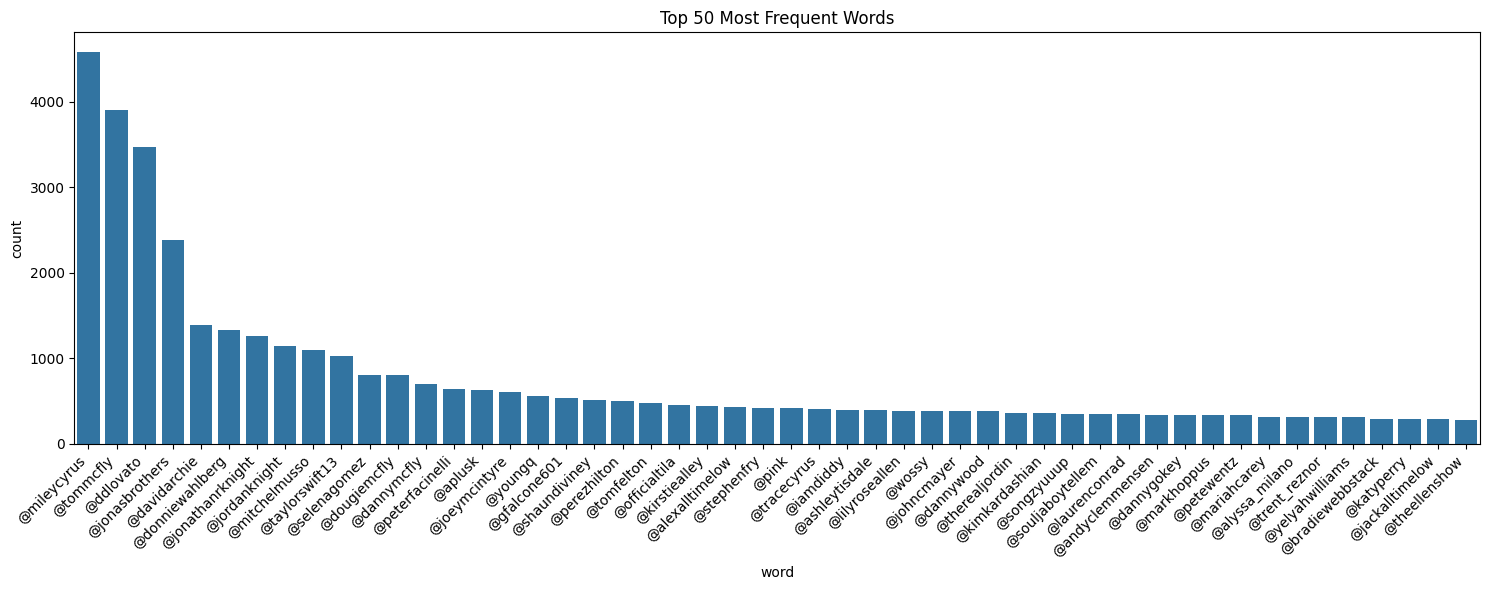

In [72]:
mention_freq_df = tweets['Text'].str.lower().str.findall(r'@\w+').explode().value_counts().reset_index()
mention_freq_df.columns = ['word', 'count']
plot_top_words(mention_freq_df, 50)

In [73]:
positive_mention_freq_df = tweets[tweets['Target'] == 4]['Text'].str.lower().str.findall(r'@\w+').explode().value_counts().reset_index()
positive_mention_freq_df.columns = ['word', 'count']

negative_mention_freq_df = tweets[tweets['Target'] == 0]['Text'].str.lower().str.findall(r'@\w+').explode().value_counts().reset_index()
negative_mention_freq_df.columns = ['word', 'count']

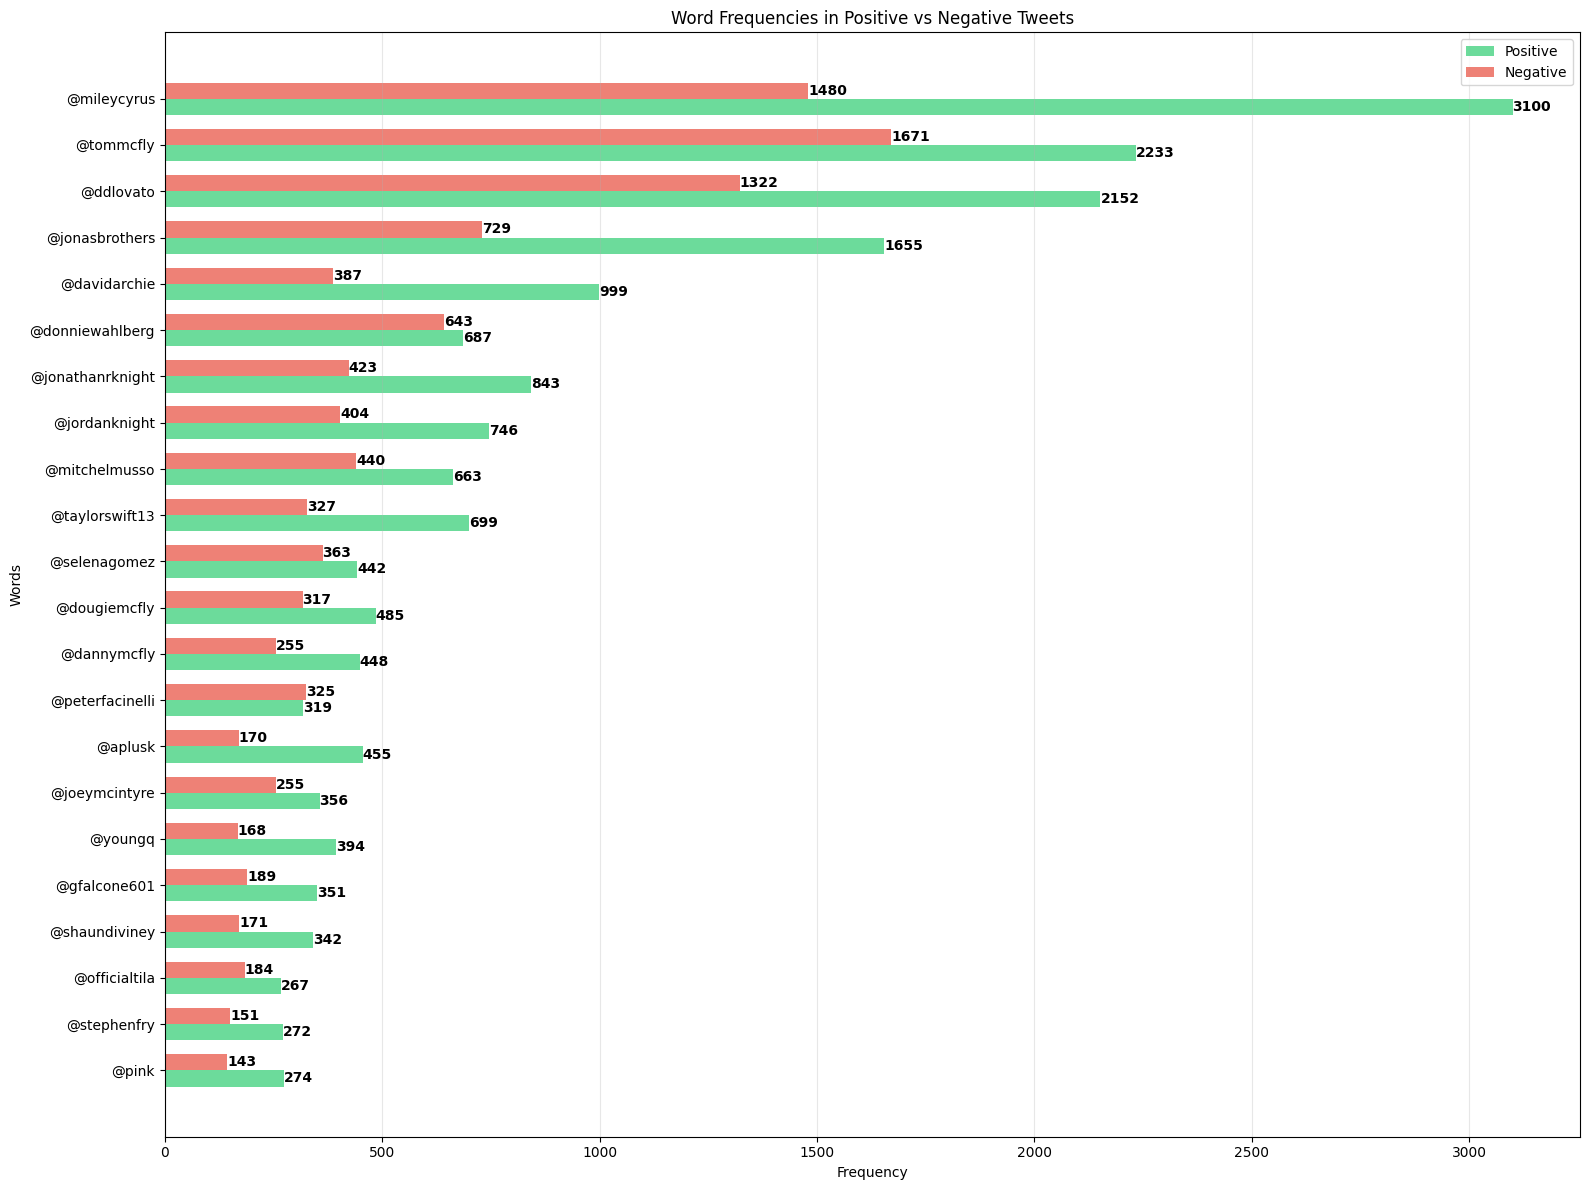

In [74]:
comparison_data = plot_sentiment_word_comparison(positive_mention_freq_df, 
                                               negative_mention_freq_df, 
                                               top_n=30)

## Language Features:
- Punctuation usage across sentiments
- URL presence analysis
- Capital letter usage

In [80]:
def plot_punctuation_comparison(pos_df, neg_df):
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Set positions for bars
    x = np.arange(len(pos_df))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, pos_df['per_tweet'], width, 
            label='Positive', color='green', alpha=0.6)
    plt.bar(x + width/2, neg_df['per_tweet'], width, 
            label='Negative', color='red', alpha=0.6)
    
    # Customize plot
    plt.xlabel('Punctuation Type')
    plt.ylabel('Average Usage per Tweet')
    plt.title('Punctuation Usage in Positive vs Negative Tweets')
    plt.xticks(x, pos_df['punctuation'], rotation=45)
    plt.legend()
    
    # Add value labels
    for i, v in enumerate(pos_df['per_tweet']):
        plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(neg_df['per_tweet']):
        plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

### Punctuation usage across sentiments

In [78]:
# Define punctuation patterns
punct_patterns = {
    'period': r'\.',
    'comma': r',',
    'exclamation': r'!+',  # Catches multiple exclamation marks
    'question': r'\?+',    # Catches multiple question marks
    'semicolon': r';',
    'colon': r':',
    'quotes': r'["\']',
    'parentheses': r'[$$$$]',
    'brackets': r'[$$$$]',
    'braces': r'[\{\}]',
    'ellipsis': r'\.{3,}',  # Three or more periods
    'emoji_punctuation': r'[:;][\'"]?[-~]?[)\]DPp]'  # Basic emoji made with punctuation
}

def count_punctuation(text_series, pattern):
    return text_series.str.count(pattern).sum()

# For positive sentiment
positive_punct_counts = {}
positive_tweets = tweets[tweets['Target'] == 4]['Text']

for punct_name, pattern in punct_patterns.items():
    positive_punct_counts[punct_name] = count_punctuation(positive_tweets, pattern)

positive_punct_freq_df = pd.DataFrame(list(positive_punct_counts.items()), 
                                    columns=['punctuation', 'count'])

# For negative sentiment
negative_punct_counts = {}
negative_tweets = tweets[tweets['Target'] == 0]['Text']

for punct_name, pattern in punct_patterns.items():
    negative_punct_counts[punct_name] = count_punctuation(negative_tweets, pattern)

negative_punct_freq_df = pd.DataFrame(list(negative_punct_counts.items()), 
                                    columns=['punctuation', 'count'])

positive_tweet_count = len(tweets[tweets['Target'] == 4])
negative_tweet_count = len(tweets[tweets['Target'] == 0])

positive_punct_freq_df['per_tweet'] = positive_punct_freq_df['count'] / positive_tweet_count
negative_punct_freq_df['per_tweet'] = negative_punct_freq_df['count'] / negative_tweet_count

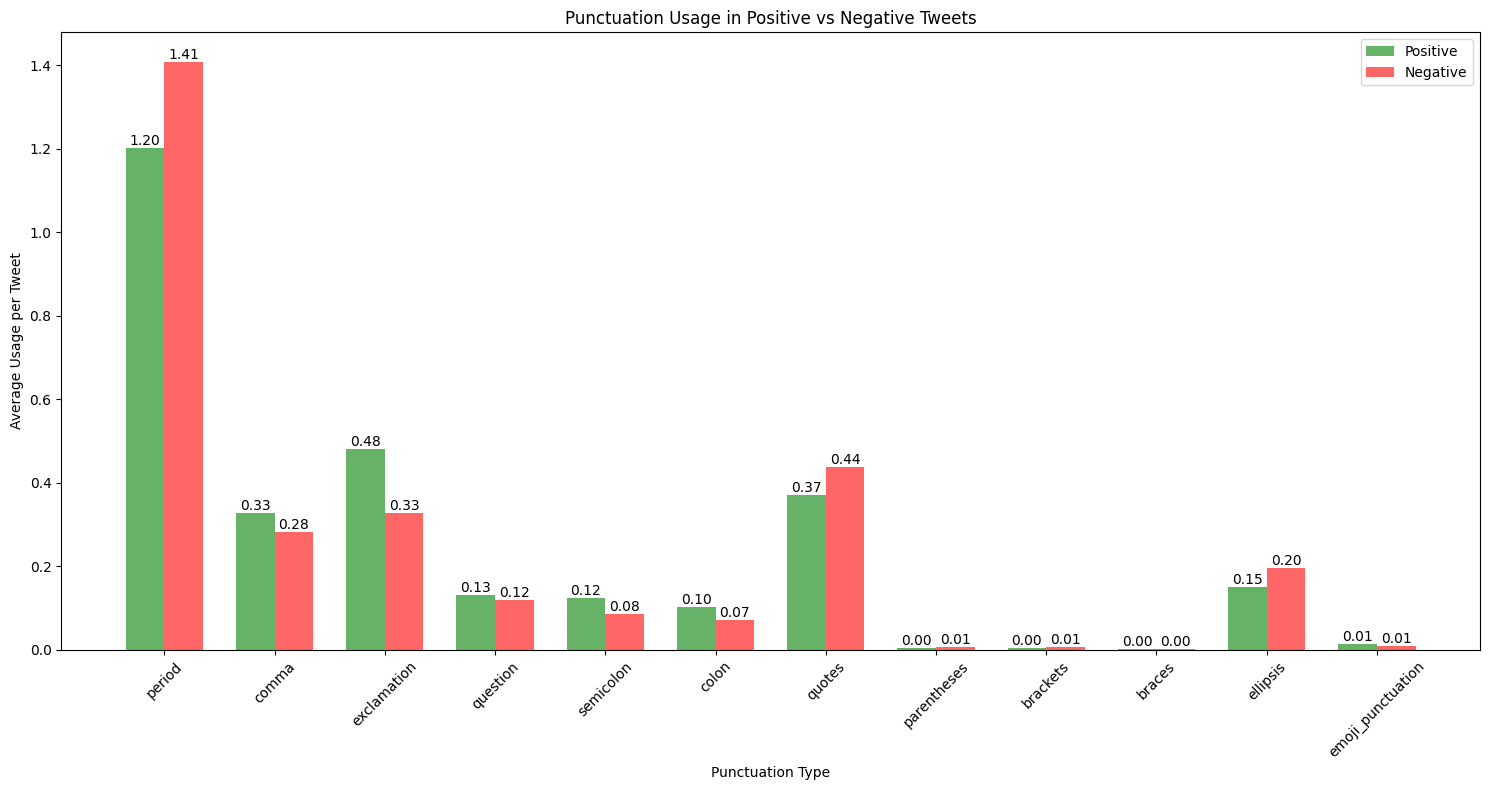

In [79]:
plot_punctuation_comparison(positive_punct_freq_df, negative_punct_freq_df)

In [91]:
url_positive_freq = len(tweets[tweets['Target'] == 4]['Text'].str.lower().str.findall(r'http[^ ]*').explode())
url_negative_freq = len(tweets[tweets['Target'] == 0]['Text'].str.lower().str.findall(r'http[^ ]*').explode())
print(f"URL use in positive posts: {url_positive_freq}\nURL use in negative posts: {url_negative_freq}")

URL use in positive posts: 801066
URL use in negative posts: 800388


In [110]:
caps_positive_freq = len(tweets[tweets['Target'] == 4]['Text'].str.findall(r'[A-Z]').explode())/len(tweets[tweets['Target'] == 4]['Text'].str.findall(r'[a-zA-Z]').explode())
caps_negative_freq = len(tweets[tweets['Target'] == 0]['Text'].str.findall(r'[A-Z]').explode())/len(tweets[tweets['Target'] == 0]['Text'].str.findall(r'[a-zA-Z]').explode())
print(f"Caps use in positive posts: {caps_positive_freq}\nCaps use in negative posts: {caps_negative_freq}")

Caps use in positive posts: 0.06504093074065806
Caps use in negative posts: 0.05879759421602248


## Time-Based Analysis:
- Sentiment patterns by:
    * Hour of day
    * Day of week
    * Month/Season

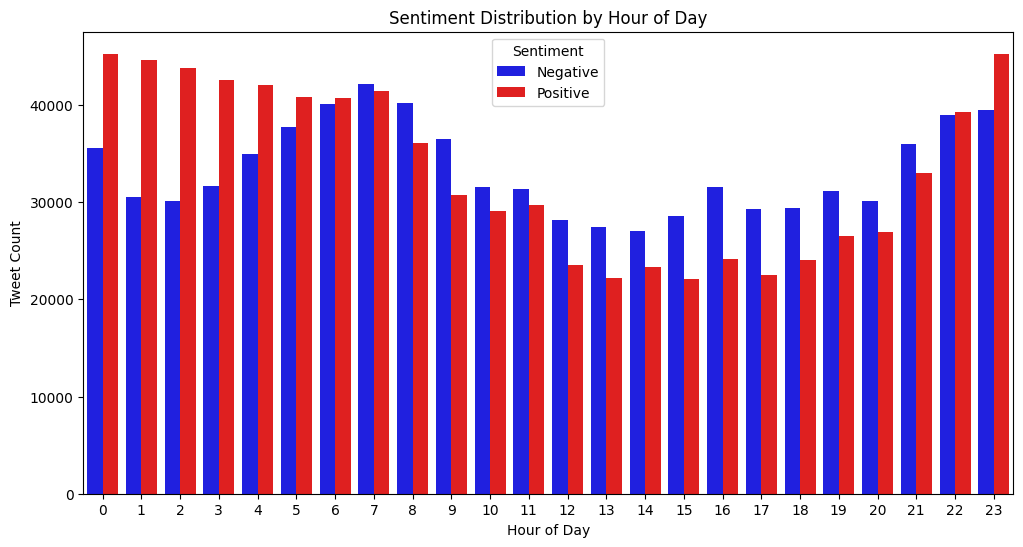

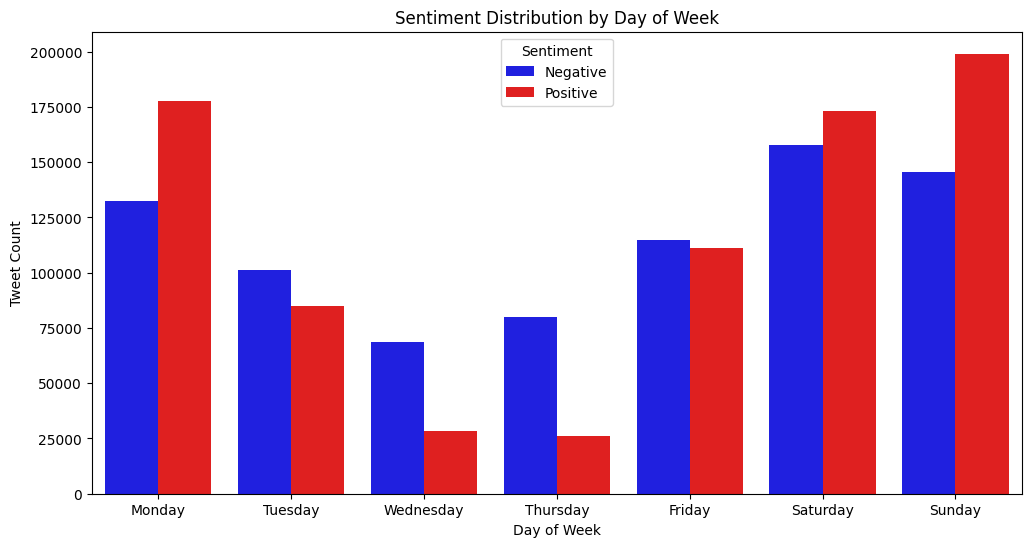

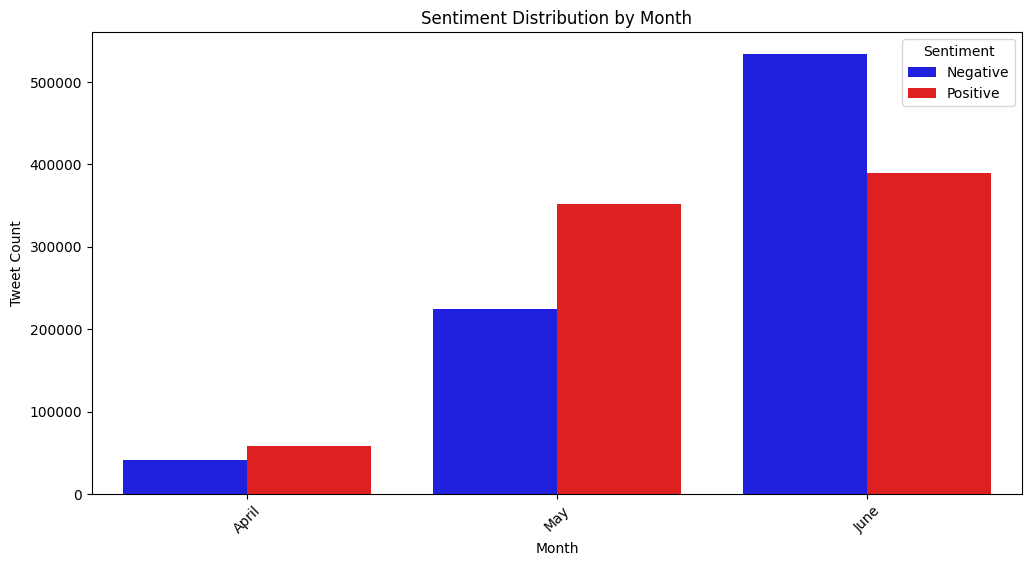

In [107]:
tweets["Date"] = pd.to_datetime(tweets["Date"], errors='coerce')
tweets["Hour"] = tweets["Date"].dt.hour
tweets["DayOfWeek"] = tweets["Date"].dt.day_name()
tweets["Month"] = tweets["Date"].dt.month_name()
tweets["Year"] = tweets["Date"].dt.year

tweets["Sentiment"] = tweets["Target"].map({0: "Negative", 4: "Positive",2:"neutral"})

# 1. Sentiment by Hour of Day
plt.figure(figsize=(12,6))
sns.countplot(data=tweets, x="Hour", hue="Sentiment", palette=["blue", "red"])
plt.title("Sentiment Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.show()


# 2. Sentiment by Day of Week
plt.figure(figsize=(12,6))
sns.countplot(data=tweets, x="DayOfWeek", hue="Sentiment", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette=["blue", "red"])
plt.title("Sentiment Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.show()

# 3. Sentiment by Month
plt.figure(figsize=(12,6))
sns.countplot(data=tweets, x="Month", hue="Sentiment", order=["April", "May", "June"], palette=["blue", "red"])
plt.title("Sentiment Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()

## User-Based Statistics:
- Top users by tweet frequency
- User sentiment patterns

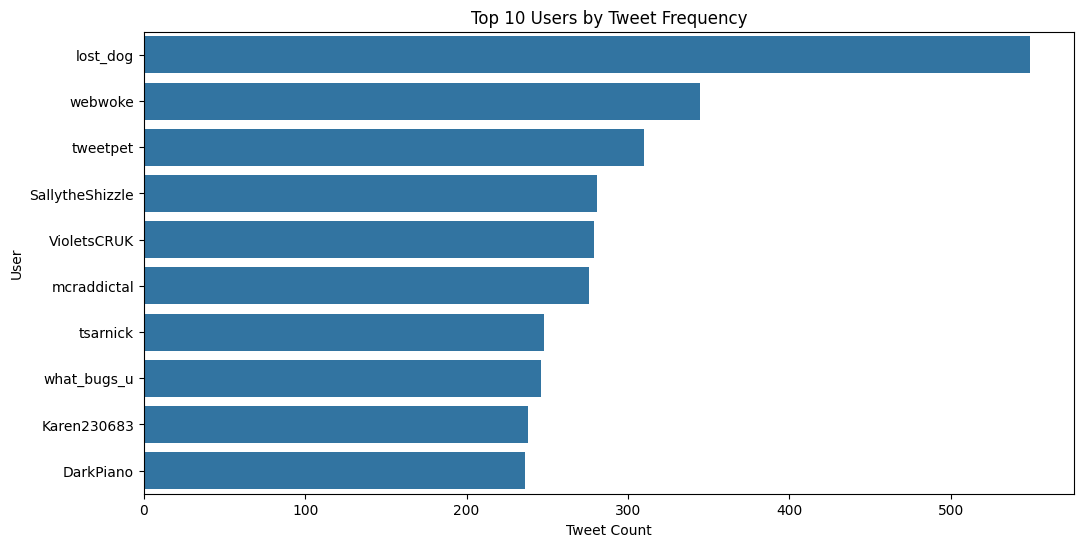

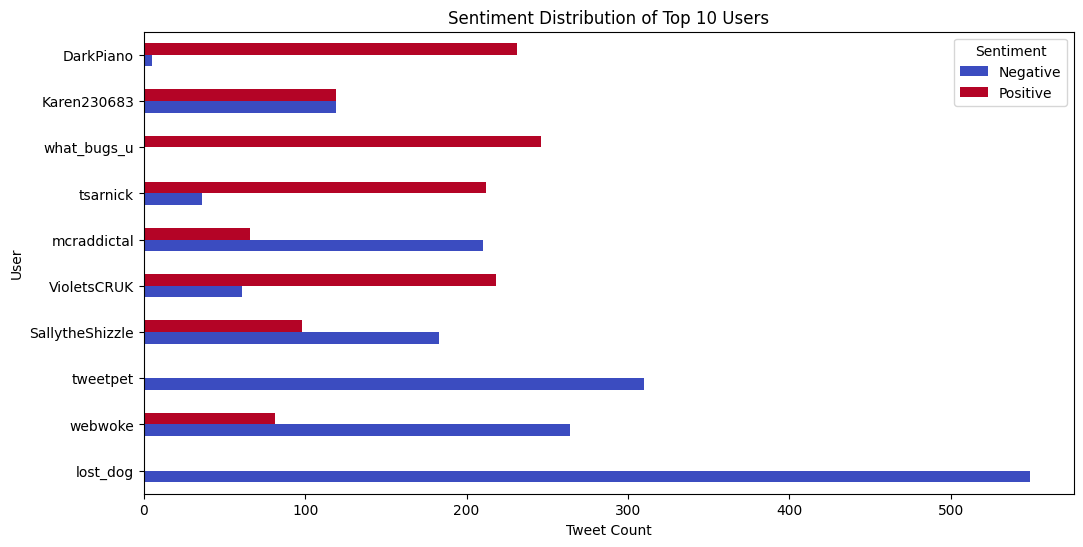

In [109]:
top_users = tweets["User"].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_users.values, y=top_users.index)
plt.title("Top 10 Users by Tweet Frequency")
plt.xlabel("Tweet Count")
plt.ylabel("User")
plt.show()

user_sentiment = tweets.groupby(["User", "Sentiment"]).size().unstack().fillna(0)
top_user_sentiment = user_sentiment.sum(axis=1).sort_values(ascending=False).head(10)
top_user_sentiment_df = user_sentiment.loc[top_user_sentiment.index]

top_user_sentiment_df.plot(kind="barh", figsize=(12,6), colormap="coolwarm")
plt.title("Sentiment Distribution of Top 10 Users")
plt.xlabel("Tweet Count")
plt.ylabel("User")
plt.legend(title="Sentiment")
plt.show()